Всем привет!


Сегодня мы поговорим о визуализации геоданных. Имея на руках статистику, явно имеющую пространственную привязку, всегда хочется сделать красивую карту. Желательно, с навигацией, инфоокнами и всплывающими подсказками. В тетрадках. И чтоб потом можно было показать всему интернету свои успехи в визуализации!

В качестве примера возьмем недавно отгремевшие муниципальные выборы в Москве. Сами данные можно взять с сайта мосгоризбиркома, в можно просто забрать датасеты с https://gudkov.ru/. Там даже есть какая-никакая визуализация, но мы пойдем глубже. Итак, что же у нас в итоге должно получиться?

Меня заинтересовала ситуация в Южном Административном Округе, а конкретно - в районе Нагатинский затон. Потратив некоторое время на написание парсера, я таки получил нужные мне данные. Итак, начнем с импортов. Помимо pandas, нам понадобятся библиотеки для работы с http-запросами и html-страницами.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
import os

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
os.environ["http_proxy"] = "http://192.168.130.151:81"
os.environ["https_proxy"] = "https://192.168.130.151:81"

Дальше нам труебуется забрать данные с самого сайта Избиркома. Берем сразу ссылку на Москву:

In [4]:
url = "http://www.moscow_city.vybory.izbirkom.ru/region/moscow_city"
response = requests.get(url)
page = BeautifulSoup(response.content, "lxml")

Я решил создать большой словарь с датафреймами внутри.

Для превращения html-страниц в датафреймы я использовал read_html, эмпирически подбирал нужные датафрейс, а после этого делал небольшую обработку, выкидывая лишнее и добавляя недостающее. Предварительно я уже обработал данные по партиям. Изначально  они были не особо читаемы. К тому же, встречается разное написание одних и тех же партий (забавно, но в некоторых случаях это не разное написание, а реально разные партии).

In [5]:
party_aliases = {
    'Региональное отделение политической партии "Российская партия пенсионеров за справедливость" в городе Москве': 'Российская партия пенсионеров за справедливость',
    'Московское городское региональное отделение Общероссийской политической партии "НАРОД ПРОТИВ КОРРУПЦИИ"': 'Народ против коррупции',
 'Региональное отделение политической партии СПРАВЕДЛИВАЯ РОССИЯ в городе Москве': 'Справедливая Россия',
 'Региональное отделение в г. Москве политической партии "Российский общенародный союз"': 'Российский общенародный союз',
 'Региональное отделение в городе Москва Политической партии "Национальный курс"': 'Национальный курс',
 'Региональное отделение ВСЕРОССИЙСКОЙ ПОЛИТИЧЕСКОЙ ПАРТИИ "РОДИНА" в городе Москве': 'Родина',
 'Региональное отделение политической партии "Объединенная партия людей ограниченной трудоспособности России" в городе Москве': 'Объединенная партия людей ограниченной трудоспособности России',
 'Региональное отделение Всероссийской политической партии "Союз Труда" в городе Москве': 'Союз Труда',
 'Региональная общественная организация содействия защите законных прав и интересов граждан "За права горожан"': 'За права горожан',
 'Региональное отделение политической партии "Российская партия пенсионеров за социальную справедливость" в городе Москве': 'Российская партия пенсионеров за социальную справедливость',
 'Всероссийская политическая партия "Интернациональная партия России"': 'Интернациональная партия России',
 'Региональное отделение в городе Москве Политической партии "Российская экологическая партия "Зелёные"': 'Зелёные',
 'Московское городское отделение политической партии ЛДПР - Либерально-демократической партии России': 'ЛДПР',
 'МОСКОВСКОЕ ГОРОДСКОЕ ОТДЕЛЕНИЕ политической партии КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ': 'Коммунистическая партия Коммунисты России',
 'Региональное отделение Политической партии "Российский Объединённый Трудовой Фронт" в городе Москве': 'Российский Объединённый Трудовой Фронт',
 'Региональное отделение Политической партии СПРАВЕДЛИВАЯ РОССИЯ в городе Москве': 'Справедливая Россия',
 'Московское городское отделение Всероссийской политической партии "ПАРТИЯ РОСТА"': 'Партия роста',
 'Всероссийская политическая партия "Гражданская инициатива"': 'Гражданская инициатива',
 'Московское городское отделение ПОЛИТИЧЕСКОЙ ПАРТИИ "АЛЬЯНС ЗЕЛЕНЫХ"': 'Альянс Зеленых',
 'МОСКОВСКОЕ ГОРОДСКОЕ ОТДЕЛЕНИЕ Политической партии КОММУНИСТИЧЕСКАЯ ПАРТИЯ КОММУНИСТЫ РОССИИ': 'Коммунистическая партия Коммунисты России',
 'Региональное отделение в Москве Политической партии "Партия народной свободы (ПАРНАС)"': 'ПАРНАС',
 'Московское городское региональное отделение Политической партии "ПАРТИЯ ВЕТЕРАНОВ РОССИИ"': 'Партия ветеранов России',
 'Региональное отделение в городе Москва Политической партии "Демократическая правовая Россия"': 'Демократическая правовая Россия',
 'Региональное отделение в городе Москве Всероссийской политической партии "Партия Возрождения Села"': 'Партия Возрождения Села',
 'Региональное отделение в Москве Политической партии "Партия народной свободы" (ПАРНАС)': 'ПАРНАС',
 'Общественная организация - Политическая партия "Партия Возрождения России"': 'Партия Возрождения России',
 'Региональное отделение Политической партии "Общероссийская политическая партия "ДОСТОИНСТВО" в городе Москва': 'Достоинство',
 'Региональное отделение Политической партии "Российская объединенная демократическая партия "ЯБЛОКО" в городе Москве': 'Яблоко',
 'РЕГИОНАЛЬНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ ПО СОДЕЙСТВИЮ И РАЗВИТИЮ СЕМЬИ И МОЛОДЕЖИ "ВРЕМЯ ПЕРЕМЕН"': 'Время Перемен',
 'МОСКОВСКОЕ ГОРОДСКОЕ ОТДЕЛЕНИЕ политической партии "КОММУНИСТИЧЕСКАЯ ПАРТИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ"': 'КПРФ',
 'Московское городское региональное отделение Всероссийской политической партии "ЕДИНАЯ РОССИЯ"': 'Единая Россия',
 'Региональное отделение Общественной организации Всероссийская политическая партия "Гражданская Сила" в г. Москве': 'Гражданская сила',
 'Московское городское отделение Политической партии ЛДПР - Либерально-демократической партии России': 'ЛДПР',
 'Региональное отделение Всероссийской политической партии "ПАРТИЯ ДЕЛА" в г. Москве': 'Партия Дела',
 'Региональная общественная организация содействия становлению благоприятных условий жизни "За комфортную среду"': 'За комфортную среду',
 'Московское городское региональное отделение политической партии "ПАТРИОТЫ РОССИИ"': 'Патриоты России',
 'Региональное отделение в городе Москве Всероссийской политической партии "Партия Великое Отечество"': 'Партия Великое Отечество',
 'Региональное отделение политической партии "Российская объединенная демократическая партия "ЯБЛОКО" в городе Москве': 'Яблоко'
}

## Разбор данных избиркома

Непосредственно сборка справочника. Что здесь происходит:
* с главной страницы избиркома собираются структура административных и муниципальных округов;
* для всего датасета собирается список партий (чтобы позже заменить мнструозные названивая на симпатичные имена);
* собираются все ссылки на Территориальные Избирательные Комиссии (ТИК);
* для каждого ТИК собирается список кандидатов;
* внутри каждого ТИК собираются Окружные Избирательные Комиссии (ОИК);
* для каждого ОИК собирается статистика по ОИК и статистика по кандидатам.

Конечно же, все данные на всякий случай сохраняем на диск. Весь процесс занимает 10-15 минут.

In [6]:
dump_folder = '/data01/jupyter/notebooks/habr/ods_votes/tmp'

In [ ]:
votes = {'atd':'', 'data':{}}

admin_data = pd.read_html(url)[7]
admin_data.columns = ['admin','municipal']
admin_data = admin_data.iloc[1:,:]
admin_data = admin_data.fillna(method='ffill')
admin_data['municipal'] = admin_data['municipal'].str.replace('Выборы депутатов Совета депутатов муниципального округа ', '')
admin_data['municipal'] = admin_data['municipal'].str.replace('Выборы депутатов муниципального Собрания внутригородского муниципального образования ', '')
admin_data['municipal'] = admin_data['municipal'].str.replace('Выборы депутатов Совета депутатов городского округа ', '')
admin_data['municipal'] = admin_data['municipal'].str.replace(' в городе Москве', '')
admin_data['municipal'] = admin_data['municipal'].str.strip()
admin_data['admin'] = admin_data['admin'].str.replace('город Москва ','')
admin_data['admin'] = admin_data['admin'].str.replace(' административный округ','')
admin_data['admin'] = admin_data['admin'].str.strip()
votes['atd'] = admin_data
admin_data.to_csv(os.path.join(dump_folder, 'atd.csv'), sep=';')

main_links = page.find_all('a')
for main_tag in main_links:
    main_link = main_tag.get('href',None)
    if 'region=77'in main_link:
        name = main_tag.text.replace('Выборы депутатов Совета депутатов муниципального округа ', '').replace('Выборы депутатов муниципального Собрания внутригородского муниципального образования ', '').replace('Выборы депутатов Совета депутатов городского округа ', '').replace(' в городе Москве', '').strip()
        votes['data'][name] = {'votes':{}}
        region_page = BeautifulSoup(requests.get(main_link).content, "lxml")
        tik_tags = region_page.find_all('option')
        region_tags = region_page.find_all('a')
        for region_tag in region_tags:
            region_link = region_tag.get('href',None)
            if 'type=220'in region_link:
                candidates = []
                for i in range(1,6):
                    candidates_link = region_link + '&number=' + str(i)
                    try:
                        candidates_df = pd.read_html(candidates_link, encoding='cp1251')[5].iloc[:,1:]
                        candidates_df.columns = ['name','date', 'party', 'okrug', 'drived', 'registered', 'elected']
                        candidates.append(candidates_df)
                    except:
                        pass
                candidates = pd.concat(candidates, axis=0).reset_index().drop('index',axis=1)
                votes['data'][name]['candidates'] = candidates
                candidates.to_csv(os.path.join(dump_folder, ('data_' + name + '_candidates.csv')), sep=';')
        for tik_tag in tik_tags:
            tik_link = tik_tag.get('value',None)
            if tik_link is not None:
                okrug = int(tik_tag.text[-1])
                tik_page = BeautifulSoup(requests.get(tik_link).content, "lxml")
                okrug_tags = tik_page.find_all('a')
                for okrug_tag in okrug_tags:
                    okrug_link = okrug_tag.get('href',None)
                    if 'type=424'in okrug_link:
                        dd = pd.read_html(okrug_link)
                        okrug_df = pd.concat([dd[6], dd[7]], axis=1)
                        okrug_columns = ['parameter', 'overall'] + list(okrug_df.iloc[0,:])[3:]
                        candidates_columns = ['name', 'overall'] + list(okrug_df.iloc[0,:])[3:]
                        okrug_stats = okrug_df.iloc[1:13,1:]
                        candidates_stats = okrug_df.iloc[14:,1:]
                        okrug_stats.columns = okrug_columns
                        candidates_stats.columns = candidates_columns
                        okrug_stats.to_csv(os.path.join(dump_folder, ('data_' + name + '_' + str(okrug) + '_okrug_stats.csv')), sep=';')
                        candidates_stats.to_csv(os.path.join(dump_folder, ('data_' + name + '_' + str(okrug) + '_candidates_stats.csv')), sep=';')
                        okrug_stats = {'okrug_stats': okrug_stats, 'candidates_stats': candidates_stats}
                        votes['data'][name]['votes'][okrug] = okrug_stats

Построим же статистику выборов по муниципальным округам.

In [8]:
data = []
for okrug in list(votes['data'].keys()):
    candidates = votes['data'][okrug]['candidates'].replace(to_replace={'party':party_aliases})#.fillna('неизбр.')
    #candidates = candidates[candidates['elected'] == 'избр.']
    #print(okrug)
    group_parties = candidates[['party','elected']].groupby('party').count()
    sum_parties = group_parties.sum().values[0]
    data_parties = candidates[['party','elected']].groupby('party').count().reset_index()
    data_parties['percent'] = data_parties['elected']/sum_parties*100
    tops = data_parties.sort_values('elected', ascending=False)
    top1 = tops.iloc[0,:3]
    top2 = tops.iloc[1,:3]
    top3 = tops.iloc[2,:3]
    top4 = tops.iloc[3,:3]
    top5 = tops.iloc[4,:3]
    #a = pd.pivot_table(data_parties[['party','elected']], columns=['party']).reset_index().iloc[:,1:]
    #b = pd.pivot_table(data_parties[['party','percent']], columns=['party']).reset_index().iloc[:,1:]
    #a.columns = ['elected.'+i for i in list(a.columns)]
    #b.columns = ['percent.'+i for i in list(b.columns)]
    #c = pd.concat([a,b],axis=1)
    c = pd.DataFrame({'okrug':okrug}, index=[0])
    c['top1'], c['top1_elected'], c['top1_percent'] = top1
    c['top2'], c['top2_elected'], c['top2_percent'] = top2
    c['top3'], c['top3_elected'], c['top3_percent'] = top3
    c['total'] = sum_parties
    c['full'] = (top1[1] == sum_parties)
    data.append(c)
winners = pd.concat(data,axis=0)

## Базовая работа с геоданными в geopandas

Для работы с геоданными мы будем использовать библиотеку geopandas. Что такое geopandas? Это расширение функциональности pandas географическими абстракциями (унаследованными из Shapely), которые позволяют нам проводит аналитические географические операции с геоданными: выборки, оверлей, аггрегация (как, например, в PostGIS для Postgresql).

Напомню, что существует три базовых типа геометрии - точка, линия (а точнее, полилиния, так как состоит из соединенных отрезков) и полигон. У всех у них бывает вариает мульти-(Multi), где геометрия представляет собой объединение отдельных географических образований в один. Например, выход метро может быть точкой, но несколько выходов, объединенных в сущность "станция", уже являются мультиточкой.

##### Небольшое отступление

Следует обратить внимание, что geopandas неохотно ставится через pip в стандартной установке Python в среде Windows. Проблема, как обычно, в зависимостях. Geopandas опирается на абстракции библиотеки fiona, у которой нет официальных сборок под Windows. Идеально использовать среду Linux, например, в docker-контейнере. Кроме того, в Windows можно использовать менеджер conda, он все зависимости подтягивает из своих репозиториев.

C геометрией муниципальных образований все достаточно просто. Их можно легко забрать из OpenStreetMap или, например, из выгрузок NextGIS. Я использую уже готовые шейпы.

Итак, начнем! Выполняем нужные ипорты, активируем графики matplotlib...

In [9]:
import geopandas as gpd

In [10]:
%matplotlib inline

In [12]:
mo_gdf = gpd.read_file('/data01/jupyter/notebooks/habr/ods_votes/atd/mo.shp')

In [13]:
mo_gdf

,NAME,OKATO,OKTMO,NAME_AO,OKATO_AO,ABBREV_AO,TYPE_MO,geometry
0,Киевский,45298555,45945000,Троицкий,45298000,Троицкий,Поселение,"(POLYGON ((36.8031012 55.4408329, 36.8031903 5..."
1,Филёвский Парк,45268595,45328000,Западный,45268000,ЗАО,Муниципальный округ,"POLYGON ((37.4276499 55.7482092, 37.4284863 55..."
2,Новофёдоровское,45298567,45954000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.8035692 55.4516224, 36.8045117 55..."
3,Роговское,45298575,45956000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.9372397 55.2413907, 36.9372604 55..."
4,"""Мосрентген""",45297568,45953000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.4395575 55.6273129, 37.4401803 55..."
5,Вороновское,45298553,45943000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((36.9700765 55.3548495, 36.9703153 55..."
6,Михайлово-Ярцевское,45298564,45951000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((37.0527376 55.3947315, 37.0548294 55..."
7,Марушкинское,45297562,45949000,Новомосковский,45297000,Новомосковский,Поселение,"POLYGON ((37.0869749 55.5903604, 37.0949245 55..."
8,Первомайское,45298572,45955000,Троицкий,45298000,Троицкий,Поселение,"POLYGON ((37.0922795 55.4649172, 37.0933611 55..."
9,Матушкино,45272562,45331000,Зеленоградский,45272000,ЗелАО,Муниципальный округ,"POLYGON ((37.1785294 56.0079518, 37.1808275 56..."


Как видите, это привычный DataFrame. Поле geometry - представление географических объектов (в данном случае - полигонов) в виде WKT, well known text (подробнее - https://en.wikipedia.org/wiki/Well-known_text). Можно довольно просто построить карту наших объектов.

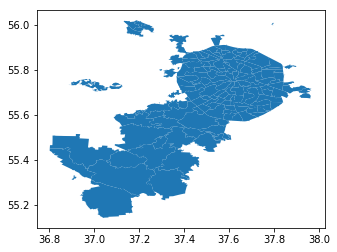

In [14]:
mo_gdf.plot();

Угадывается Москва! Правда, не совсем привычо выглядит. Причина в проекции карты. На Хабре уже есть отличный ликбез по ним: https://habrahabr.ru/post/235283/

Итак, представим наши данные в более привычной проекции Web Mercator (исходную проекцию можно легко получить по параметру crs). Окрасим полигоны по названию Административного округа. Ширину линий выставим 0,5. Метод окраски cmap использует стандартные значения matplotlib (если вы, как и я, не помните их наизусть, то вот шпаргалка: http://matplotlib.org/users/colormaps.html). Чтобы увидеть легенду карты,  задаем параметр legend. Ну а figsize отвечает за размер нашей карты.

{'init': 'epsg:4326'}


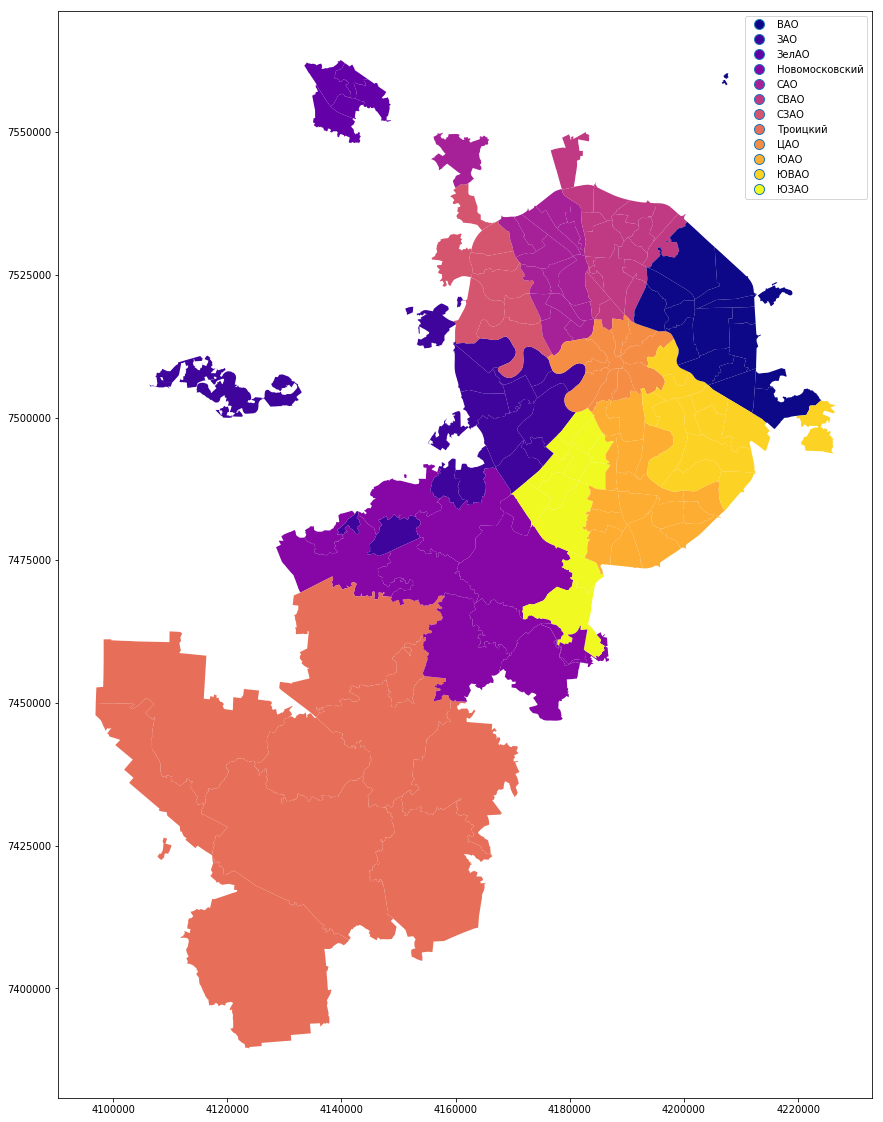

In [15]:
print(mo_gdf.crs)
mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'})
mo_gdf_wm.plot(column = 'ABBREV_AO', linewidth=0.5, cmap='plasma', legend=True, figsize=[20,20]);

Можно построить карту и по типу муниципального образования

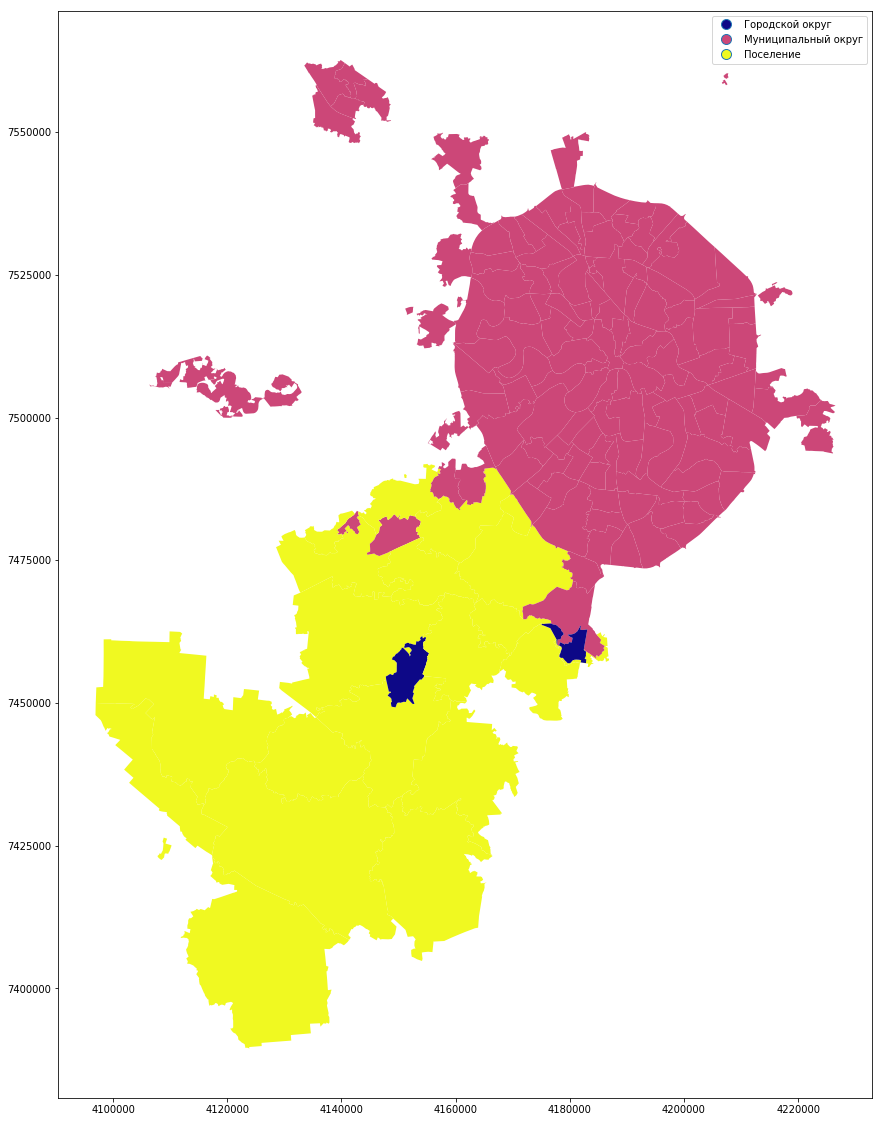

In [16]:
mo_gdf_wm.plot(column = 'TYPE_MO', linewidth=0.5, cmap='plasma', legend=True, figsize=[20,20]);

Итак построим карту статистики по муниципальным округам. Ранее мы уже создали датафрейм winners.

In [17]:
winners.head()

,okrug,top1,top1_elected,top1_percent,top2,top2_elected,top2_percent,top3,top3_elected,top3_percent,total,full
0,Богородское,Единая Россия,10,66.666667,Самовыдвижение,2,13.333333,Справедливая Россия,2,13.333333,15,False
0,Вешняки,Единая Россия,15,100.000000,Альянс Зеленых,0,0.000000,КПРФ,0,0.000000,15,True
0,Восточное Измайлово,Единая Россия,10,100.000000,КПРФ,0,0.000000,Коммунистическая партия Коммунисты России,0,0.000000,10,True
0,Восточный,Справедливая Россия,6,60.000000,Единая Россия,4,40.000000,КПРФ,0,0.000000,10,False
0,Гольяново,Время Перемен,0,NaN,Единая Россия,0,NaN,КПРФ,0,NaN,0,True


Нам необходимо соединить наш датафрейм с геодатафреймом для создания карты. Немного причешем названия мунициальных округов, чтобы соединение произошло без сюрпризов.

In [18]:
winners['municipal_low'] = winners['okrug'].str.lower()
winners['municipal_low'] = winners['municipal_low'].str.replace('ё', 'е')
mo_gdf_wm['name_low'] = mo_gdf_wm['NAME'].str.lower()
mo_gdf_wm['name_low'] = mo_gdf_wm['name_low'].str.replace('ё', 'е')

In [19]:
full_gdf = winners.merge(mo_gdf_wm[['geometry', 'name_low']], left_on='municipal_low', right_on='name_low', how='left')
full_gdf = gpd.GeoDataFrame(full_gdf)

Построим простую категориальная карту, где от от желтого к зеленому распределены партии-победители. В районе Щукино в этом году и правда не было выборов.

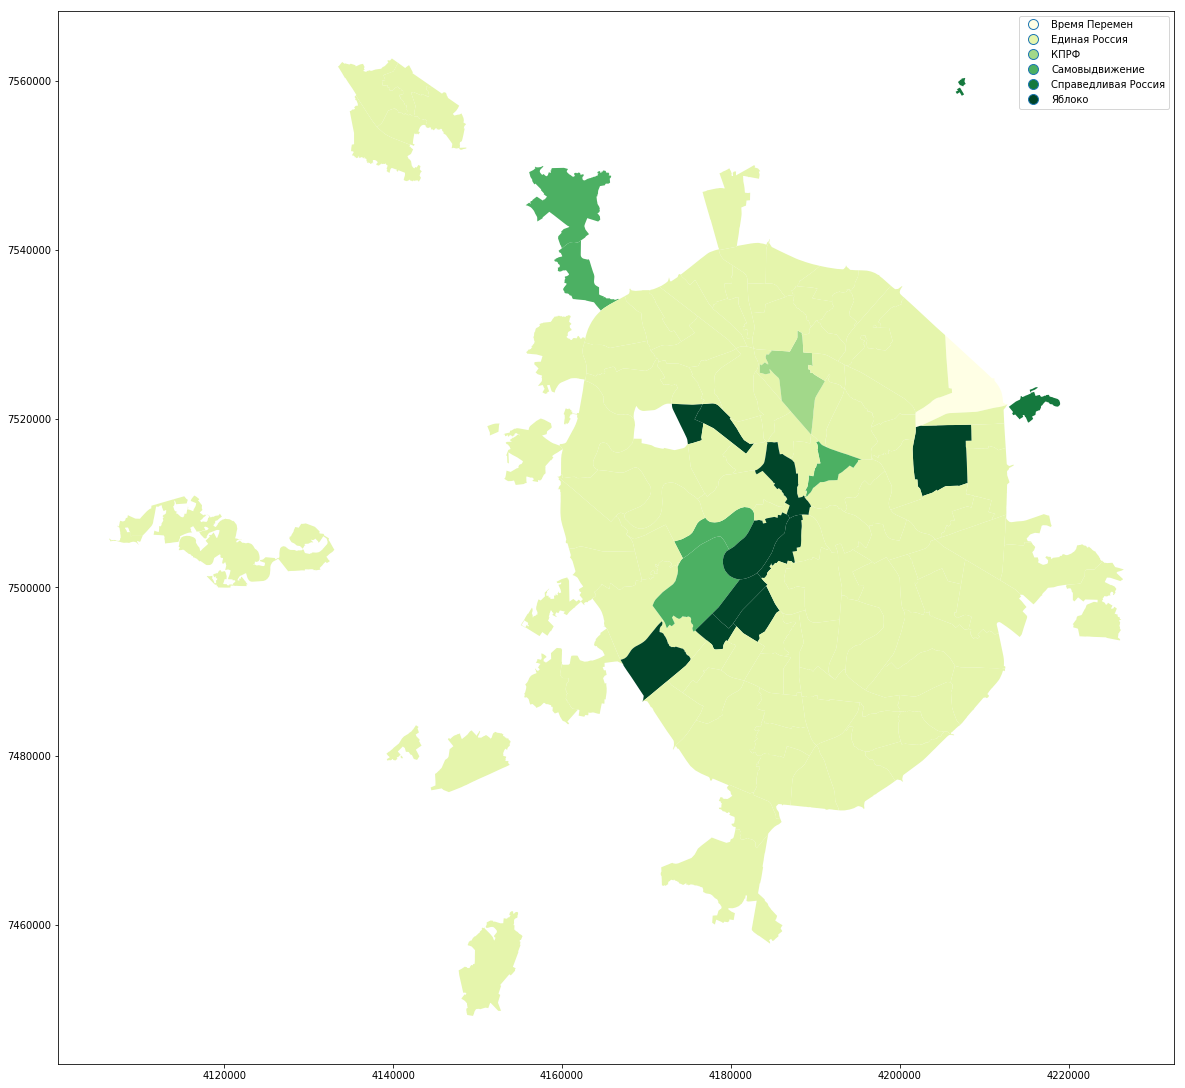

In [23]:
map = full_gdf.plot(column = 'top1', linewidth=0, cmap='YlGn', legend=True, figsize=[20,20])

Отлично! У нас получилась симпатичная визуализация. Но хочется и базовую карту, и навигацию, и инфоокна! На помощь нам придет библиотека cartoframes

## Визуализация геоданных с помощью cartoframes

Одним из самых удобных инструментов для визуализации геоданных является Carto. Для работы с этим сервисом существуюет библиотеке cartoframes, которая позволяет работать с функциями сервиса прямо из тетрадок Jupyter.

##### Важное отступление

Библиотека cartoframes требует внимательного обращение под Windows в силу особенностей разработки. С кириллическими данными можно легко отстрелить себе ногу. Лучше ее использовать или в docker-контейнере, или на полноценном Linux. Ставится библиотека только через pip. В windows ее можно успешно установить, предварительно поставив geopandas через conda (или поставив все зависимости руками).

Cartoframes адекватно работает с проекцией WGS84. В нее и перепроецируем наш датасет.

In [25]:
full_gdf.crs = ({'init' :'epsg:3857'})
full_gdf = full_gdf.to_crs({'init' :'epsg:4326'})

Импортируем нужные библиотеки, поключаемся к Carto, заливаем наш датасет.

In [27]:
import cartoframes
import json
import warnings
warnings.filterwarnings("ignore")

In [29]:
USERNAME = 'zhukov' #ваш пользователь Carto
APIKEY = 'bbb8957d171e21e30601d0152d381d5cbfaae3eb' #Ваш ключ API

In [30]:
cc = cartoframes.CartoContext(api_key=APIKEY, base_url='https://{}.carto.com/'.format(USERNAME))

In [59]:
cc.write(full_gdf[['top1', 'okrug','geometry', 'total']], encode_geom=True, table_name='mo_votes', overwrite=True)

Table successfully written to CARTO: https://zhukov.carto.com/dataset/mo_votes


Датасет можно выгрузить с Carto обратно. Увы, полноценный геодатафрейм пока только в проекте. Можно с помощью gdal и shapley сконвертировать бинарное представление геометрии PostGIS снова в WKT.

In [67]:
test_gdf = cc.read('mo_votes')
test_gdf.head()

,field_1,okrug,the_geom,the_geom_str,the_geom_webmercator,top1,total
cartodb_id,,,,,,,
2,1,Вешняки,0103000020E6100000010000003D00000006605EDB36E2...,0103000000010000003d00000006605edb36e2424067bd...,0103000020110F0000010000003D0000008BE54820B309...,Единая Россия,15
20,19,Кунцево,0106000020E61000000500000001030000000100000013...,0106000000050000000103000000010000001300000017...,0106000020110F00000500000001030000000100000013...,Единая Россия,10
100,99,Зюзино,0103000020E610000001000000470000000802751431C8...,010300000001000000470000000802751431c842408ebb...,0103000020110F00000100000047000000958DBA8D32E7...,Единая Россия,15
32,31,Савелки,0103000020E6100000010000003B020000BF5A5AB2CF9A...,0103000000010000003b020000c05a5ab2cf9a424063f3...,0103000020110F0000010000003B020000D03D5A421D9A...,Единая Россия,10
69,68,Куркино,0103000020E610000001000000200200003C51C8844EAE...,010300000001000000200200003c51c8844eae424050a6...,0103000020110F0000010000002002000044DA2CAC3ABB...,Самовыдвижение,10


Наконец, карта! Разукрасим данные, положим на базовую карту и включим навигацию. Подсмотреть схемы окрашивания можно здесь :https://github.com/CartoDB/CartoColor/wiki/CARTOColor-Scheme-Names

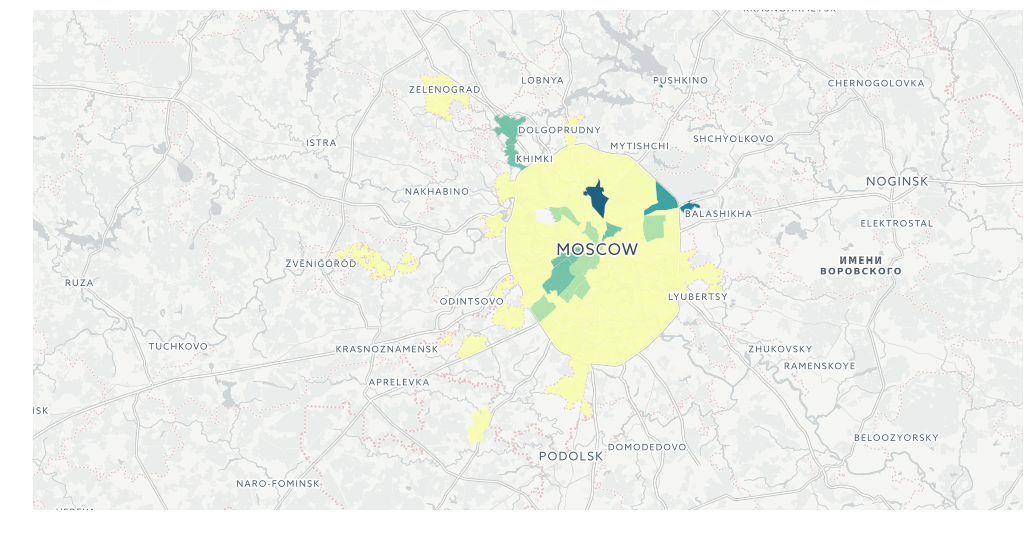

In [90]:
from cartoframes import Layer, BaseMap, styling
l = Layer('mo_votes', color={'column': 'top1', 'scheme': styling.bluYl(5, bin_method='category')})
map = cc.map(layers=[BaseMap(source='light', labels='front'), l], size=(990, 500), interactive=False)

In [92]:
map

Следует заметить, что в данный момент cartoframes не позволяет встроить инфоокна прямо в окно тетрадки, показывать легенду, а также публиковать карты на Carto. Но эти опции в процессе имплементации.

Итоговый результат в самом Carto может выглядеть вот так:

In [89]:
from IPython.display import HTML
HTML('<iframe width="100%" height="520" frameborder="0" src="https://zhukov.carto.com/builder/66ca6e98-5dcd-478c-b5a9-9efd5c74d872/embed" allowfullscreen webkitallowfullscreen mozallowfullscreen oallowfullscreen msallowfullscreen></iframe>')

# TODO

## Визуализация УИКов (рефакторинг)

Посмотрим, как выглядит списк кандидатов в Нагатинском затоне

In [ ]:
zaton = votes['data']['Нагатинский затон']

In [ ]:
zaton_cantidates = zaton['candidates']
zaton_cantidates

Причешем его немного. Добавим нормальные названия партий и заполним поле избрания. Намного лучше, не правда ли?

In [ ]:
zaton_cantidates = zaton_cantidates.replace(to_replace={'party':party_aliases}).fillna('неизбр.')
zaton_cantidates

Теперь можно заняться непосредственно данными ОИК. В Нагатинском затоне их 2. Однако у кандидатов не указана их партийная принадлежность. Исправим это.

In [ ]:
zaton_candidates_1 = zaton['votes'][1]['candidates_stats']
zaton_candidates_1

In [ ]:
zaton_candidates_2 = zaton['votes'][2]['candidates_stats']
zaton_candidates_2

In [ ]:
my_zaton = new_zaton.merge(uik_geo[['address_voting', 'number_official', 'lat', 'lon', 'place_voting']], left_on='uik', right_on='number_official', how='inner')

In [ ]:
percent_zaton = (zaton.groupby(['uik', 'variable'])['value'].sum().groupby(level = 0)).transform(lambda x: x/x.sum())
sum_zaton = zaton.groupby(['uik'])['value'].sum()
sum_zaton = pd.DataFrame(sum_zaton).reset_index()
sum_zaton = sum_zaton.rename(columns={'value':'sum'})
percent_zaton = pd.DataFrame(group_zaton).reset_index()
percent_zaton = percent_zaton.rename(columns={'value':'percent'})
#group_zaton[group_zaton['variable'] == 'Единая Россия']
new_zaton = percent_zaton[percent_zaton['variable'] == 'Единая Россия']
new_zaton = percent_zaton[percent_zaton['variable'] == 'Единая Россия'][['uik', 'percent']].merge(sum_zaton[['uik','sum']], left_on='uik', right_on='uik', how='inner')
new_zaton[['uik']] = new_zaton[['uik']].apply(pd.to_numeric)
new_zaton.sort_values('percent', ascending=False)

In [ ]:
uik_geo = pd.read_csv(r'77\77.csv')

In [ ]:
my_zaton = new_zaton.merge(uik_geo[['address_voting', 'number_official', 'lat', 'lon', 'place_voting']], left_on='uik', right_on='number_official', how='inner')

In [ ]:
from shapely.geometry import Polygon, Point

In [ ]:
my_zaton['geometry'] = my_zaton.apply(lambda z: Point(z.lon, z.lat), axis=1)

In [ ]:
my_zaton_gdf = gpd.GeoDataFrame(my_zaton)

In [ ]:
my_zaton_gdf.to_file(r"D:\work\data\zaton.shp", encoding = 'utf-8')

## Визуализация явки (в процессе)

## Визуализация данных data.mos.ru (не начато)

## data.mos.ru

Добавим к нашей визулизации данные с портала data.mos.ru

In [ ]:
apidatamos_key = '0b3fb6302ef49fb6f68cd7a2d7adc5f6'
apidatamos_baseurl = 'https://apidata.mos.ru/v1/features/'
apidatamos_velo = '916'
velo_url = apidatamos_baseurl + apidatamos_velo + '?api_key=' + apidatamos_key

In [ ]:
import json
from pandas.io.json import json_normalize

In [ ]:
velodata = json.loads(requests.get(velo_url).content)['features']

In [ ]:
velodata_df = json_normalize(velodata)

In [ ]:
velodata_df